In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as pl
import seaborn as sns

sns.set_context('poster')

import postprocessing
DPI = 300

In [2]:
results = postprocessing.compute_results('./results_cuda_naive_with_overheads.csv')

In [3]:
def make_walltime_plot(results, color, fill_color=None, logx=False, logy=False):
    nbodies = results['bodies']
    fig, ax = pl.subplots(nrows=1, ncols=1, figsize=(14, 14))
    
    ax.plot(nbodies, results['mean'], color=color, label='Mean wall time', marker='o')
    
    if fill_color:
        ax.fill_between(nbodies, results['lower'], results['upper'], color=fill_color, label="95% CI")
    
    pl.grid(True, linestyle=':')
    ax.set_xlabel("N")
    ax.set_ylabel("Wall time (s)")
    

    if logy:
        pl.yscale('log')
    if logx:
        pl.xscale('log', basex=2)
        
    pl.legend()
    
    sns.despine()
    
    return fig, ax

In [4]:
nvidia_color = '#7CD000'

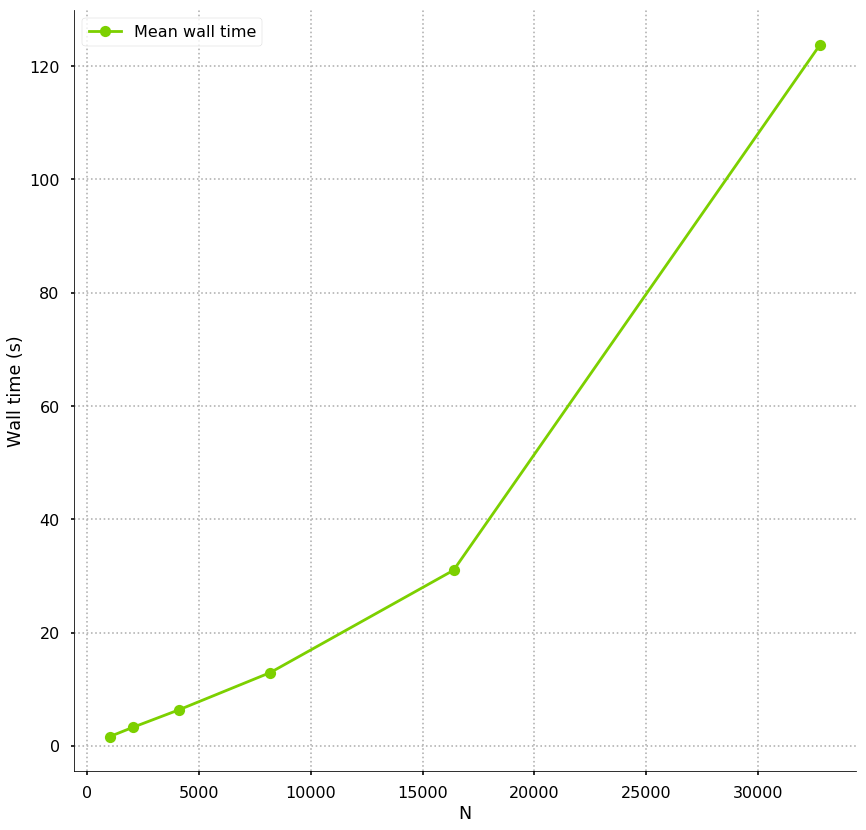

In [5]:
fig, ax = make_walltime_plot(results, nvidia_color, logx=False, logy=False)
pl.savefig('./img/wall_time.png', bbox_inches='tight', dpi=DPI)

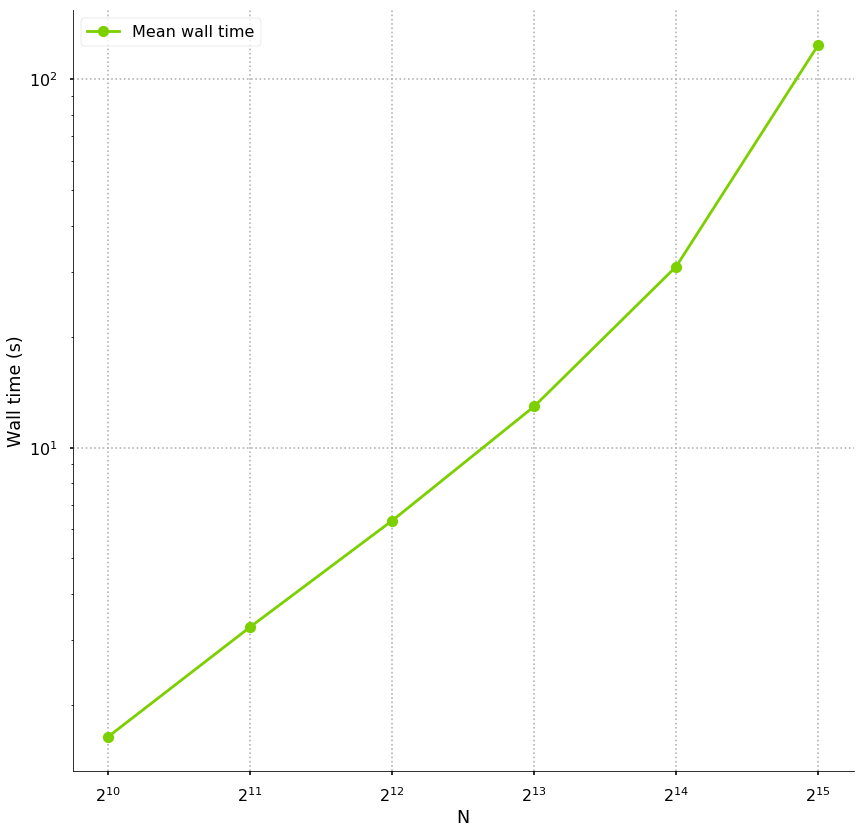

In [6]:
fig, ax = make_walltime_plot(results, nvidia_color, logx=True, logy=True)
pl.savefig('./img/wall_time_log.png', bbox_inches='tight', dpi=DPI)

## Plot di confronto con versione CPU

In [7]:
results_cpu = pd.read_csv('./results_static.csv')

In [8]:
results_cpu.loc[:, 'elapsed'] = results_cpu['end'] - results_cpu['start']

In [9]:
def make_cpu_gpu_plot(results_gpu, results_cpu: pd.DataFrame, threads, colors, logx=False, logy=False):
    nbodies = results_gpu['bodies'][:-2]
    print(nbodies)
    fig, ax = pl.subplots(nrows=1, ncols=1, figsize=(12, 12))
    
    cpu_time = []
    for nb in np.unique(results_cpu['nbodies'].values):
        tmp = results_cpu.query('nbodies == @nb & threads == @threads')
        cpu_time.append(np.mean(tmp['elapsed'].values))
    
    ax.plot(nbodies, results_gpu['mean'][:-2], color=colors[0], label='CUDA wall time', marker='o')
    ax.plot(nbodies, cpu_time, color=colors[1], label='OpenMP wall time', marker='d')
    
    pl.grid(True, linestyle=':')
    ax.set_xlabel("N")
    ax.set_ylabel("Wall time (s)")
    
    title = "Wall time of OpenMP and CUDA versions"
    if logx or logy:
        title = title + " (log scales)"
    pl.title(title)
    

    if logy:
        pl.yscale('log')
    if logx:
        pl.xscale('log', basex=2)
        
    pl.legend()
    
    sns.despine()
    
    return fig, ax

[1024 2048 4096 8192]


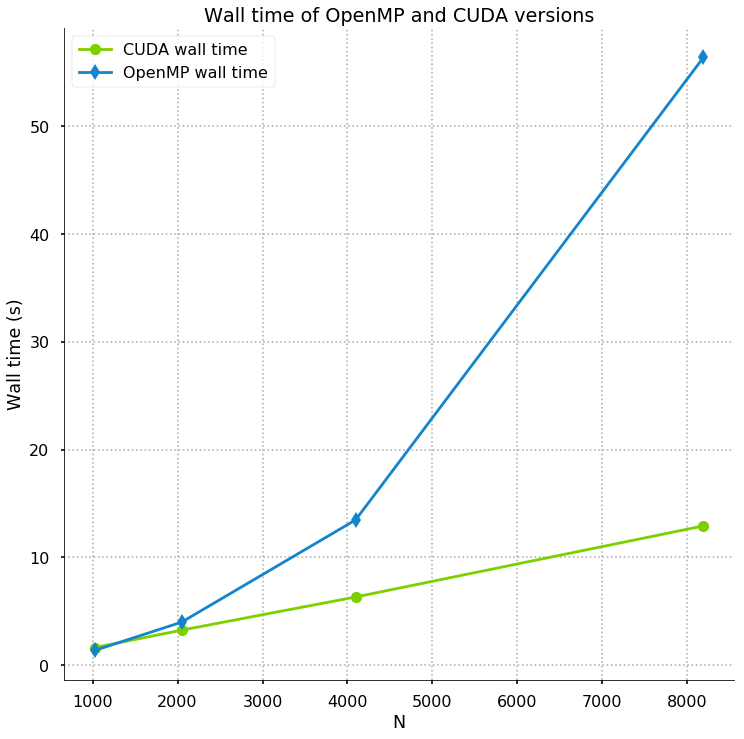

In [10]:
colors = (nvidia_color, '#1485CC')
threads = 14
fig, ax = make_cpu_gpu_plot(results, results_cpu, threads, colors, logx=False, logy=False)
pl.savefig('./img/wall_time_cuda_openmp.png', bbox_inches='tight', dpi=DPI)

[1024 2048 4096 8192]


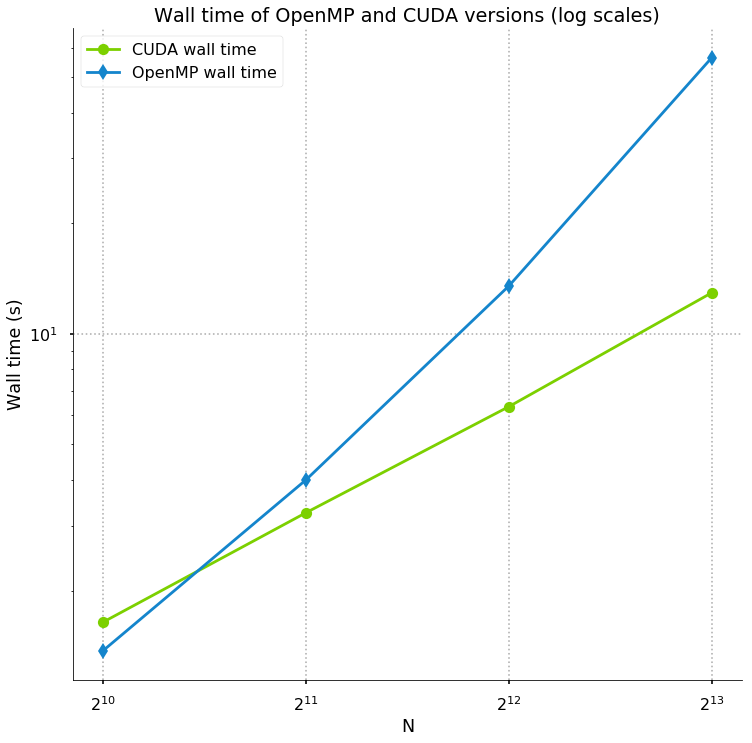

In [11]:
fig, ax = make_cpu_gpu_plot(results, results_cpu, threads, colors, logx=True, logy=True)
pl.savefig('./img/wall_time_cuda_openmp_log.png', bbox_inches='tight', dpi=DPI)

In [12]:
print("Data for table in Google Documents:")
for i, n in enumerate(results['bodies']):
    print("N = {:6d} \t mean = {:8.2f} \t IC_width = {:4.2f}".format(
    n, results['mean'][i], (results['mean'][i] - results['lower'][i])))

Data for table in Google Documents:
N =   1024 	 mean =     1.64 	 IC_width = 0.00
N =   2048 	 mean =     3.26 	 IC_width = 0.00
N =   4096 	 mean =     6.33 	 IC_width = 0.00
N =   8192 	 mean =    12.93 	 IC_width = 0.00
N =  16384 	 mean =    30.99 	 IC_width = 0.00
N =  32768 	 mean =   123.78 	 IC_width = 0.02


In [ ]:
fig_colors = [
        ('forestgreen', 'mediumseagreen'),  # 1024
        ('navy', 'lightskyblue'),  # 2048
        ('gold', 'blanchedalmond'),  # 4096
        ('firebrick', 'lightcoral'),  # 8192
]

# Analisi matematica del problema

Calcoleremo:

- overhead totale $T_O = pT_p - T_s$
- speedup $S = \frac{T_s}{T_{tot}^{par}}$
- efficienza $E = \frac{S}{p}$ che dovrà essere $E \lt 1$ se il problema non è superlineare per effetto delle cache processore
- costo $C = T_{tot}^{par}p$

In [24]:
import postprocessing_cpu

In [25]:
results_cpu = postprocessing_cpu.compute_results('./results_static.csv')

In [27]:
t_seriale_cpu = [x[0] for x in results_cpu['mean']]
t_seriale_cpu = {nb: t for nb, t in zip([1024, 2048, 4096, 8192], t_seriale_cpu)}
t_seriale_cpu

{1024: 9.389062099934867,
 2048: 36.53290986659316,
 4096: 141.87915115995332,
 8192: 578.3042048335386}

In [35]:
colors = {
    1024: 'forestgreen',
    2048: 'navy',
    4096: 'gold',
    8192: 'firebrick',
    16384: 'thistle',
}

## Overhead totale

## Caso 1: tempo seriale calcolato sulla CPU

In [36]:
results_cuda = pd.read_csv('./results_cuda_naive_for_p.csv')

In [37]:
results_cuda['p'] = results_cuda['n_blocks'] * results_cuda['threads_per_block']

In [41]:
def plot_t_overhead_cuda_cpu_seriale(results, t_seriale, colors, logx=False, logy=False, **kwargs):
    if 'figsize' in kwargs:
        print(f"User defined size is {kwargs['figsize']}")
        size = kwargs['figsize']
    else:
        size = (14, 14)
    
    fig, ax = pl.subplots(nrows=1, ncols=1, figsize=size)
    
    nbodies = [1024, 2048, 4096, 8192]

    for i, nb in enumerate(nbodies):
        tmp = results.query('nbodies == @nb')
        tmp = tmp.sort_values(by='p', ascending=True)
        p = tmp['p']
        t_over = (p * tmp['computing_time_s']) - t_seriale[nb]
        
        ax.plot(p, t_over, label="$T_O $" + "with N={}".format(nb), marker='o', color=colors[nb])

    ax.set_xlabel('p')
    ax.set_ylabel('Total parallel overhead')
    
    if logx:
        pl.xscale('log', basex=2)
    if logy:
        pl.yscale('log')
    
    pl.grid(linestyle=':')
    pl.legend()
    sns.despine()
    
    return fig, ax

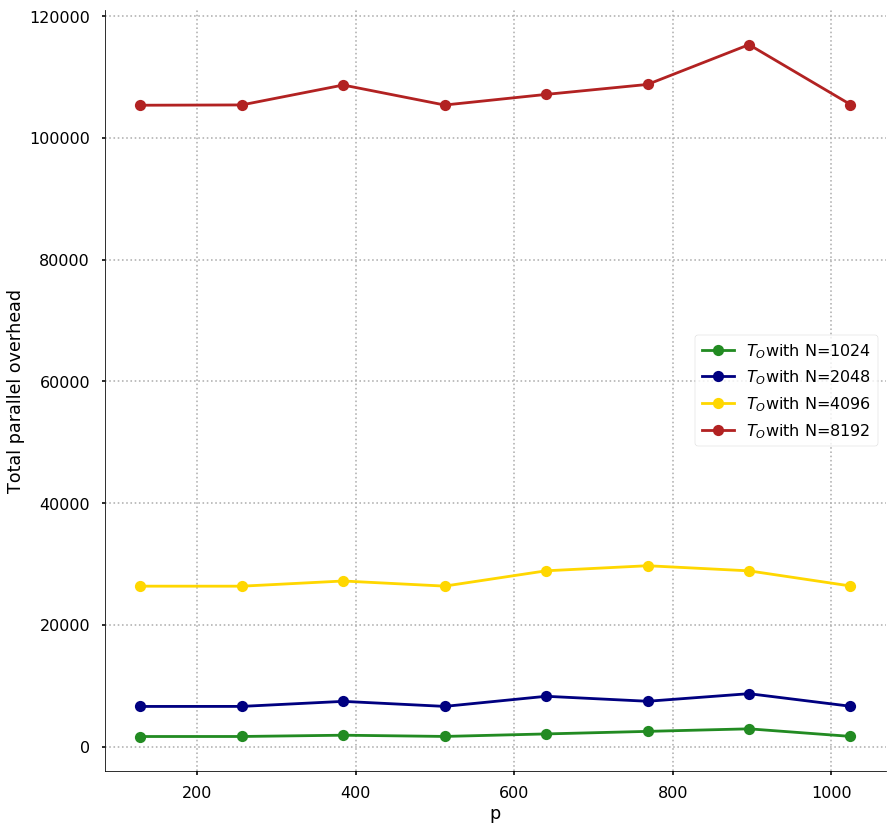

In [58]:
plot_t_overhead_cuda_cpu_seriale(results_cuda, t_seriale_cpu, colors)
pl.savefig('./img/total_parallel_overhead_CPU.png', bbox_inches='tight', dpi=DPI)

## caso 2: tempo seriale della ALU della GPU

In [59]:
results_cuda_seriale = pd.read_csv('./results_cuda_naive_serial.csv')
results_cuda_parallelo = pd.read_csv('./results_cuda_naive_for_p.csv')

In [60]:
results_cuda_seriale.loc[:, 'computing_time_s'] = results_cuda_seriale.loc[:, 'computing_time_s'] * (1000/10)
y_fit = results_cuda_seriale.sort_values(by='nbodies')['computing_time_s'].values

In [61]:
nb_seriale_originale = np.unique(results_cuda_seriale['nbodies'].values)
nb_seriale_interp = [1024, 2048, 4096, 8192, 16384] #, 32768]
polinomio = np.poly1d(np.polyfit(nb_seriale_originale, y_fit, deg=2))
interpolato = polinomio(nb_seriale_interp)

t_seriale_gpu = {nb: v for nb, v in zip(nb_seriale_interp, interpolato)}

In [62]:
results_cuda_parallelo['p'] = results_cuda_parallelo['n_blocks'] * results_cuda_parallelo['threads_per_block']

In [63]:
def plot_t_overhead_cuda_seriale_cuda(results, t_seriale, colors, logx=False, logy=False, **kwargs):
    if 'figsize' in kwargs:
        print(f"User defined size is {kwargs['figsize']}")
        size = kwargs['figsize']
    else:
        size = (14, 14)
    
    fig, ax = pl.subplots(nrows=1, ncols=1, figsize=size)

    for i, nb in enumerate(t_seriale):
        tmp = results.query('nbodies == @nb')
        tmp = tmp.sort_values(by='p', ascending=True)
        p = tmp['p']
        t_over = (p * tmp.loc[:, 'computing_time_s']) - t_seriale[nb]
        
        ax.plot(p, t_over, label="$T_O $" + "with N={}".format(nb), marker='o', color=colors[nb])

    ax.set_xlabel('p')
    ax.set_ylabel('Total parallel overhead')
    
    if logx:
        pl.xscale('log', basex=2)
    if logy:
        pl.yscale('log')
    
    pl.grid(linestyle=':')
    pl.legend()
    sns.despine()
    
    return fig, ax

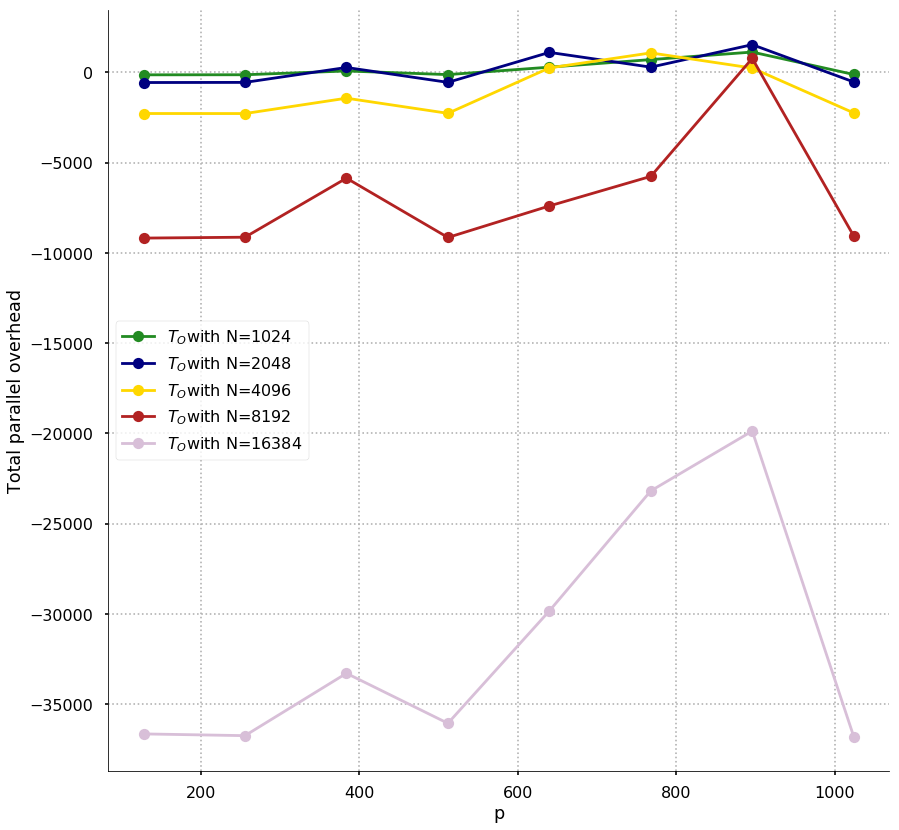

In [64]:
plot_t_overhead_cuda_seriale_cuda(results_cuda, t_seriale_gpu, colors)
#pl.savefig('./img/total_parallel_overhead_GPU.png', bbox_inches='tight', dpi=DPI)

### Caso 3: tempo seriale come baseline è 1 blocco da 128 threads

In [119]:
def plot_overhead_con_cuda_baseline(results, colors, logx=False, logy=False, **kwargs):
    if 'figsize' in kwargs:
        print(f"User defined size is {kwargs['figsize']}")
        size = kwargs['figsize']
    else:
        size = (14, 14)
    
    fig, ax = pl.subplots(nrows=1, ncols=1, figsize=size)
    
    bodies = np.unique(results['nbodies'].values)
    p = np.unique(results['p'].values)

    for i, nb in enumerate(bodies):
        tmp = results.query('nbodies == @nb')
        tmp = tmp.sort_values(by='p', ascending=True)
        
#        print(tmp)

        p = tmp['n_blocks'].values
        t_seriale = tmp.iloc[0, 1]
        
        tp = tmp.iloc[1:, 1].values
        
        p_tp = p[1:] * tp
        t_over = p_tp - t_seriale
        print(t_over)
        
        ax.plot(p[1:], t_over, label="$T_O $" + "with N={}".format(nb), marker='o', color=colors[nb])

    ax.set_xlabel('p = $N_{blocks}$')
    ax.set_ylabel('Total parallel overhead')
    
    if logx:
        pl.xscale('log', basex=2)
    if logy:
        pl.yscale('log')
    
    pl.grid(linestyle=':')
    pl.legend()
    sns.despine()
    
    return fig, ax

[0.029594 1.665383 0.09333  3.314409 6.58685  9.851857 0.148986]
[ 0.054848  6.513251  0.0731   13.039065  6.651584 16.386436  0.24904 ]
[-2.0309000e-02  6.6317140e+00  8.2641000e-02  1.9726663e+01
  2.6227201e+01  1.9662860e+01  2.5959700e-01]
[ 0.38037  25.927398  0.266478 13.90616  26.707428 77.745282  0.917786]
[ -0.755371  26.220458   4.586669  53.212525 105.162353 131.036499
  -1.124755]


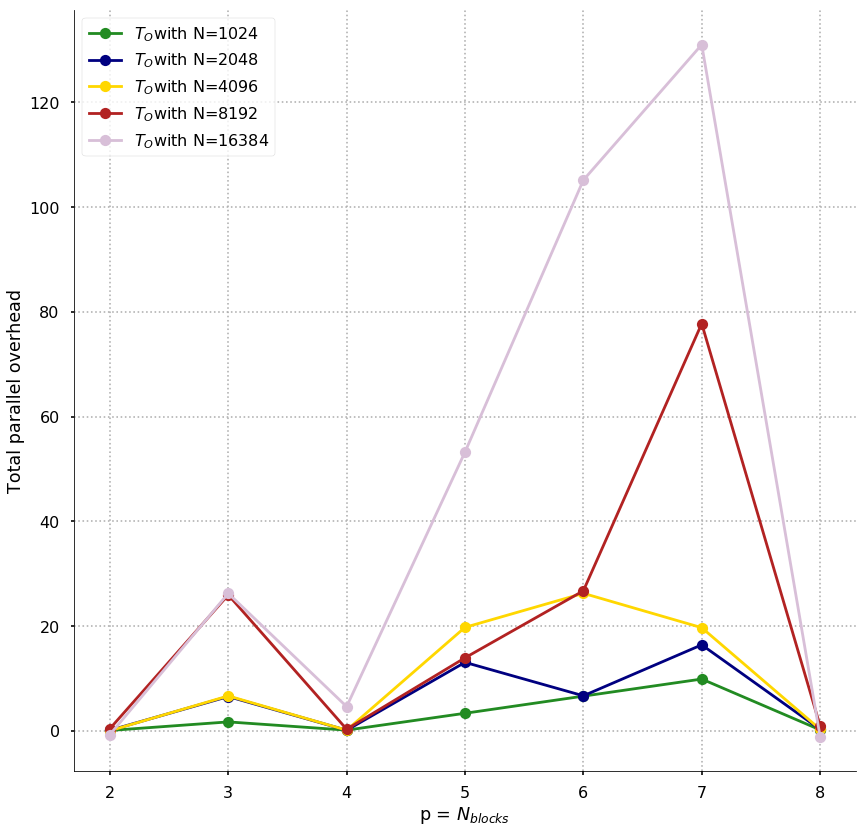

In [121]:
plot_overhead_con_cuda_baseline(results_cuda_parallelo, colors)
pl.savefig('./img/total_parallel_overhead_baseline_128.png', bbox_inches='tight', dpi=DPI)

## Speedup

In [129]:
speedup = dict() # S = Ts/Tp

bodies = np.unique(results_cuda_parallelo['nbodies'].values)

for nb in bodies:
    print(f"N = {nb}")
    tmp = results_cuda_parallelo.query('nbodies == @nb')
    tmp = tmp.sort_values(by='n_blocks')
    
    blocks = tmp['n_blocks'].values
    media = tmp['computing_time_s'].values
    t_s = media[0]
    
    inc = t_s / media
    efficienza = inc / blocks
    
    speedup[nb] = dict()
    speedup[nb]['speedup'] = inc[1:]
    speedup[nb]['blocks'] = blocks[1:]
    speedup[nb]['E'] = efficienza[1:]
    speedup[nb]['t_s'] = t_s
    
    print("Spedup rispetto a t_s = {:6.4f}".format(t_s))
    for i in range(1, len(inc)):
        print("Con {:1d} blocchi \t t_tot = {:10.2f} s\t S = {:6.2f}\t E = {:4.2f} %".format(
            blocks[i], media[i], inc[i], efficienza[i] * 100))
    
    print("")

N = 1024
Spedup rispetto a t_s = 12.9606
Con 2 blocchi 	 t_tot =       6.50 s	 S =   2.00	 E = 99.77 %
Con 3 blocchi 	 t_tot =       4.88 s	 S =   2.66	 E = 88.61 %
Con 4 blocchi 	 t_tot =       3.26 s	 S =   3.97	 E = 99.29 %
Con 5 blocchi 	 t_tot =       3.26 s	 S =   3.98	 E = 79.64 %
Con 6 blocchi 	 t_tot =       3.26 s	 S =   3.98	 E = 66.30 %
Con 7 blocchi 	 t_tot =       3.26 s	 S =   3.98	 E = 56.81 %
Con 8 blocchi 	 t_tot =       1.64 s	 S =   7.91	 E = 98.86 %

N = 2048
Spedup rispetto a t_s = 51.7515
Con 2 blocchi 	 t_tot =      25.90 s	 S =   2.00	 E = 99.89 %
Con 3 blocchi 	 t_tot =      19.42 s	 S =   2.66	 E = 88.82 %
Con 4 blocchi 	 t_tot =      12.96 s	 S =   3.99	 E = 99.86 %
Con 5 blocchi 	 t_tot =      12.96 s	 S =   3.99	 E = 79.88 %
Con 6 blocchi 	 t_tot =       9.73 s	 S =   5.32	 E = 88.61 %
Con 7 blocchi 	 t_tot =       9.73 s	 S =   5.32	 E = 75.95 %
Con 8 blocchi 	 t_tot =       6.50 s	 S =   7.96	 E = 99.52 %

N = 4096
Spedup rispetto a t_s = 206.9187
Con 2 

In [132]:
def plot_speedup(S, colors, plot_linear=False, grid=False, logy=False, logx=False, same_axes=False, **kwargs):
    if 'figsize' in kwargs:
        print(f"User defined size is {kwargs['figsize']}")
        size = kwargs['figsize']
    else:
        size = (14, 14)
        
    fig, ax = pl.subplots(nrows=1, ncols=1, figsize=size)

    for nb in S:
        current = S[nb]
        
        speedup = current['speedup']
        blocks = current['blocks']
        assert len(speedup) == len(blocks)
        t_s = current['t_s']
        
        color = colors[nb]
        
        ax.plot(blocks, speedup, color=color, marker='o', label=f"{nb} bodies")
    
    if plot_linear:
        ax.plot(blocks, blocks, linestyle=':', color='lightskyblue', label=r"speedup $\Theta(p)$")

    ax.set_xlabel("p = $N_{blocks}$")
    ax.set_ylabel("Speedup")
    
    ax.set_xlim(left=1, right=1.05 * max(blocks))
    if same_axes:
        ax.set_ylim(bottom=1, top=1.05 * max(blocks))
    else:
        ax.set_ylim(bottom=1, top=1.05 * max(speedup))

    if logy:
        pl.yscale('log')
    if logx:
        pl.xscale('log')

    pl.grid(grid, linestyle=":")
    pl.legend()
    sns.despine()

    return fig, ax

User defined size is (14, 14)


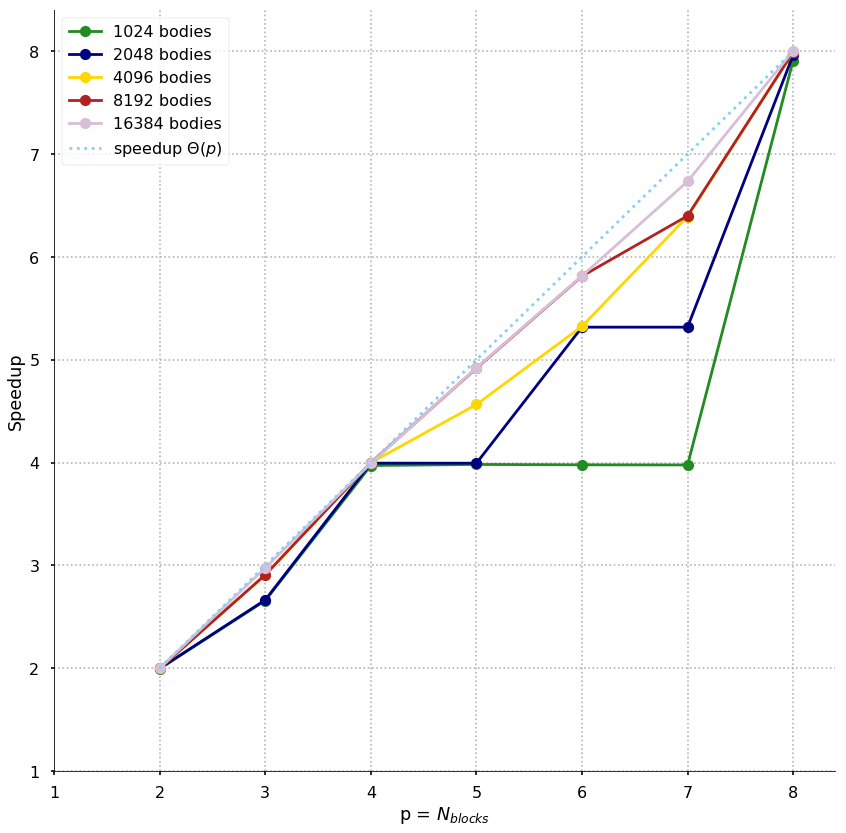

In [133]:
plot_speedup(speedup, colors, plot_linear=True, grid=True, logy=False, logx=False, same_axes=True, figsize=(14, 14))
pl.savefig('./img/speedup_baseline_128.png', bbox_inches='tight', dpi=300)

In [138]:
def plot_E(S, colors, grid=False, logy=False, logx=False, **kwargs):
    if 'figsize' in kwargs:
        print(f"User defined size is {kwargs['figsize']}")
        size = kwargs['figsize']
    else:
        size = (14, 14)
        
    fig, ax = pl.subplots(nrows=1, ncols=1, figsize=size)

    for nb in S:
        current = S[nb]
        
        E = current['E']
        blocks = current['blocks']
        assert len(E) == len(blocks)
        t_s = current['t_s']
        
        color = colors[nb]
        
        ax.plot(blocks, E, color=color, marker='o', label=f"{nb} bodies")
    
    ax.set_xlabel("p = $N_{blocks}$")
    ax.set_ylabel("E")
    
    ax.set_xlim(left=0, right=1.05 * max(blocks))
    ax.set_ylim(bottom=0, top=1.10)

    if logy:
        pl.yscale('log')
    if logx:
        pl.xscale('log')

    pl.grid(grid, linestyle=":")
    pl.legend()
    sns.despine()

    return fig, ax

User defined size is (16, 12)


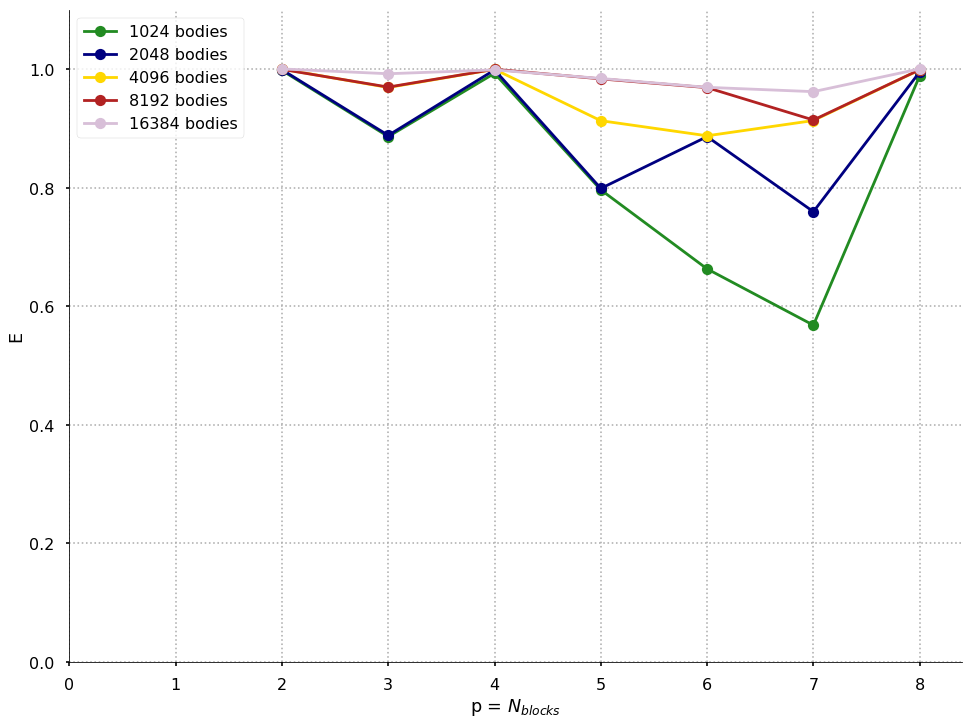

In [139]:
plot_E(speedup,
       colors,
       grid=True,
       logy=False,
       logx=False,
       figsize=(16, 12))
pl.savefig('./img/efficiency_baseline_128.png', bbox_inches='tight', dpi=300)

In [141]:
s = speedup[8192]['speedup']
for i, sp in enumerate(s):
    print("p = {:2d} \t S = {:5.2f}".format(i+2, sp))

p =  2 	 S =  2.00
p =  3 	 S =  2.91
p =  4 	 S =  4.00
p =  5 	 S =  4.92
p =  6 	 S =  5.81
p =  7 	 S =  6.40
p =  8 	 S =  7.99


## Costo

In [ ]:
def plot_costo(result, colors, grid=False, logy=False, logx=False, **kwargs):
    if 'figsize' in kwargs:
        print(f"User defined size is {kwargs['figsize']}")
        size = kwargs['figsize']
    else:
        size = (14, 14)
        
    fig, ax = pl.subplots(nrows=1, ncols=1, figsize=size)
    
    
    
    for nb in result:
        current = result[nb]
        
        t_tot = current['m']
        n_threads = current['nt']
        assert len(t_tot) == len(n_threads)

        costo = t_tot * n_threads
        
        color = colors[nb]
        
        ax.plot(n_threads, costo, color=color, marker='o', label=f"{nb} bodies")
    
    ax.set_xlabel("p")
    ax.set_ylabel("Cost")
    
#    ax.set_xlim(left=0, right=1.05 * max(n_threads))
#    ax.set_ylim(bottom=0, top=1.05 * max(costo))

    if logy:
        pl.yscale('log')
    if logx:
        pl.xscale('log')

    pl.grid(grid, linestyle=":")
    pl.legend()
    sns.despine()
    
    try:
        filepath = kwargs['savefile']
        pl.savefig(filepath, bbox_inches='tight', dpi=300)
    except KeyError:
        pass

    return fig, ax

In [ ]:
d1 = dict()
for k in d:
    tmp = {
        'nt': d[k]['nt'][1:],
        'm': d[k]['m'][1:],
    }
    d1[k] = tmp

In [ ]:
plot_costo(d1, colors, grid=True, logx=False, logy=False, figsize=(14, 10))

In [ ]:
plot_costo(d1, colors, grid=True, logx=False, logy=True, figsize=(14, 10), savefile="./cost-logy.png")